In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

import nltk

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

data = pd.read_csv(r"../../data/covtype.csv")
train_df = pd.read_csv(r"../../data/train.csv")
test_df = pd.read_csv(r"../../data/test.csv")

### Feature Engineering
# Drop "ID"
train_df = train_df.drop(columns=["Id"])

# Create Labels DF
train_labels_df = train_df[["Cover_Type"]]

# Drop Labels
train_df = train_df.drop(columns=["Cover_Type"])

# Build the np arrays
train_data = train_df.to_numpy()
test_data = test_df.drop(columns=["Id"]).to_numpy()
train_labels = train_labels_df.to_numpy().ravel()

# Shuffle the input
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data, train_labels = train_data[shuffle], train_labels[shuffle]

# Set some variables to hold dev, and training data.
dev_data, dev_labels = train_data[14000:], train_labels[14000:]
train_data, train_labels = train_data[:14000], train_labels[:14000]

## PCA

In [2]:
from sklearn.decomposition import PCA

def do_pca (t_data, n, k_principal_components):
    # Use PCA from sklearn and set number of components to the shape 
    # of the train_data feature size
    # Fit to the Train Data and get the variance ratio
    pca = PCA(n_components=n)
    pca.fit(t_data)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Find only the prinicpal_components ratios
    total_variance = []
    for k in k_principal_components:
        total_variance_ratio = sum(explained_variance_ratio[0:k])
        total_variance.append(total_variance_ratio)

    #Plot the total variance vs. number of principal components,
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(k_principal_components,total_variance)
    ax.set_ylabel("Fraction of Total Variance")
    ax.set_xlabel("Number of Principal Components")
    ax.set_title("Total Variance vs.\n Num of Principal Components") 

    #The following code constructs the Scree plot
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    per_var = per_var[per_var > 2]
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

    ax = fig.add_subplot(1,2,2)
    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    ax.set_ylabel('Percentage of Explained Variance')
    ax.set_xlabel('Principal Component')
    ax.set_title('Scree Plot of PCs with 2%\n or more Explained Variance')
    plt.show()

    #########################
    # Determine which feature had the biggest influence on PC1
    #########################
    ## Get the loading scores and sort
    loading_scores = pd.Series(pca.components_[0], index=train_df.columns)
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    top_10 = sorted_loading_scores[0:10].index.values
    ## print the gene names and their scores (and +/- sign)
    print("Top 10 features and their loading score influnce on PC1:")
    print("--------------------------------------------------------")
    print(loading_scores[top_10])

    return

def print_importances(clf):
    importances = np.round(clf.feature_importances_,4)
    features = train_df.columns.to_numpy()
    importances_df = pd.DataFrame({'feature':features,'importance':importances})
    importances_df = importances_df.sort_values('importance',ascending=False)
    importances_df = importances_df[(importances_df.sum(axis=1) != 0)]  
    print(importances_df)



### Feature Engineering

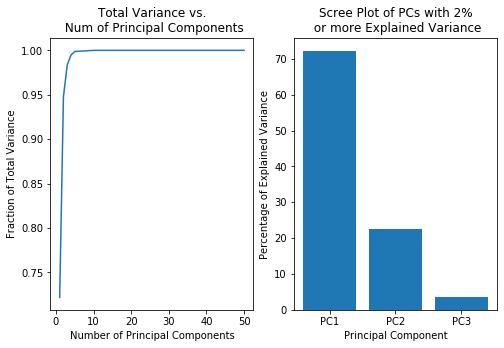

Top 10 features and their loading score influnce on PC1:
--------------------------------------------------------
Horizontal_Distance_To_Roadways       0.812089
Horizontal_Distance_To_Fire_Points    0.555661
Elevation                             0.175173
Horizontal_Distance_To_Hydrology      0.032063
Hillshade_3pm                         0.004386
Hillshade_Noon                        0.003454
Aspect                                0.001864
Slope                                -0.001711
Hillshade_9am                         0.000671
Vertical_Distance_To_Hydrology        0.000439
dtype: float64


In [3]:
data = pd.read_csv(r"../../data/covtype.csv")
train_df = pd.read_csv(r"../../data/train.csv")
test_df = pd.read_csv(r"../../data/test.csv")

### Feature Engineering
# Drop "ID"
train_df = train_df.drop(columns=["Id"])

# Create Labels DF
train_labels_df = train_df[["Cover_Type"]]

# Drop Labels
train_df = train_df.drop(columns=["Cover_Type"])

do_pca(train_df.to_numpy(), train_df.shape[1], k_principal_components = [1,2,3,4,5,10,20,30,40,50])

First thing we notice is that distances are making an influences on the loading score.  Let's normalize these to reduce their impact.

Converted all Distance/Elevation Measures to be Normal


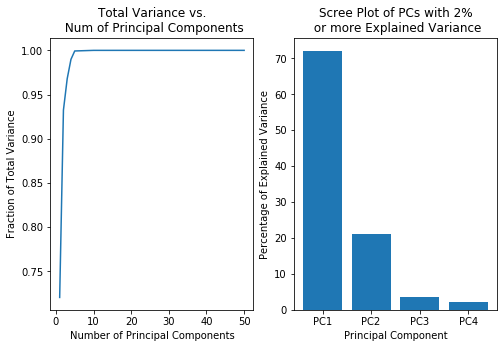

Top 10 features and their loading score influnce on PC1:
--------------------------------------------------------
Horizontal_Distance_To_Hydrology    0.979920
Vertical_Distance_To_Hydrology      0.195482
Aspect                              0.032075
Hillshade_3pm                       0.019674
Hillshade_Noon                      0.008349
Hillshade_9am                      -0.007421
Slope                              -0.001591
Wilderness_Area4                   -0.000491
Wilderness_Area3                    0.000456
Elevation_Normal                    0.000397
dtype: float64


In [4]:
train_df['Roadway_Distance_Normal'] = ((train_df['Horizontal_Distance_To_Roadways'] - train_df['Horizontal_Distance_To_Roadways'].min()) /
                (train_df['Horizontal_Distance_To_Roadways'].max() - train_df['Horizontal_Distance_To_Roadways'].min()))

test_df['Roadway_Distance_Normal'] = ((test_df['Horizontal_Distance_To_Roadways'] - test_df['Horizontal_Distance_To_Roadways'].min()) /
                 (test_df['Horizontal_Distance_To_Roadways'].max() - test_df['Horizontal_Distance_To_Roadways'].min()))

train_df = train_df.drop(columns=["Horizontal_Distance_To_Roadways"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Roadways"])

train_df['Fire_Points_Distance_Normal'] = ((train_df['Horizontal_Distance_To_Fire_Points'] - train_df['Horizontal_Distance_To_Fire_Points'].min()) /
                (train_df['Horizontal_Distance_To_Fire_Points'].max() - train_df['Horizontal_Distance_To_Fire_Points'].min()))

test_df['Fire_Points_Distance_Normal'] = ((test_df['Horizontal_Distance_To_Fire_Points'] - test_df['Horizontal_Distance_To_Fire_Points'].min()) /
                 (test_df['Horizontal_Distance_To_Fire_Points'].max() - test_df['Horizontal_Distance_To_Fire_Points'].min()))

train_df = train_df.drop(columns=["Horizontal_Distance_To_Fire_Points"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Fire_Points"])

train_df['Elevation_Normal'] = ((train_df['Elevation'] - train_df['Elevation'].min()) /
                (train_df['Elevation'].max() - train_df['Elevation'].min()))

test_df['Elevation_Normal'] = ((test_df['Elevation'] - test_df['Elevation'].min()) /
                 (test_df['Elevation'].max() - test_df['Elevation'].min()))

train_df = train_df.drop(columns=["Elevation"])
test_df = test_df.drop(columns=["Elevation"])
print("Converted all Distance/Elevation Measures to be Normal")
do_pca(train_df.to_numpy(), train_df.shape[1], k_principal_components = [1,2,3,4,5,10,20,30,40,50])

Next we see that the distance to hydrology makes a major impact.  Let's combine them into a eculidean distance and normalize the result.

Converted Distance to Hydrology


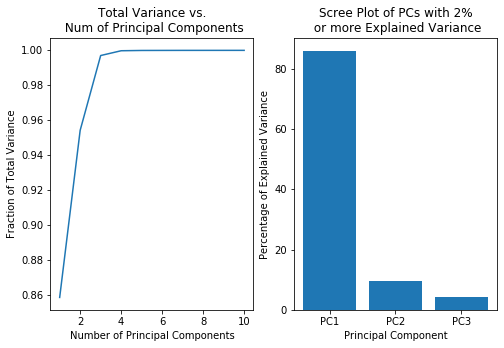

Top 10 features and their loading score influnce on PC1:
--------------------------------------------------------
Aspect              0.939804
Hillshade_3pm       0.284867
Hillshade_9am      -0.173970
Hillshade_Noon      0.073161
Slope              -0.000829
Wilderness_Area1   -0.000507
Soil_Type10         0.000384
Wilderness_Area4    0.000259
Soil_Type3         -0.000226
Soil_Type30        -0.000206
dtype: float64


In [5]:
train_df['Total_Distance_to_Hydrology'] = (train_df['Horizontal_Distance_To_Hydrology']**2 + 
                                           train_df['Vertical_Distance_To_Hydrology']**2)**0.5
test_df['Total_Distance_to_Hydrology'] = (test_df['Horizontal_Distance_To_Hydrology']**2 + 
                                          test_df['Vertical_Distance_To_Hydrology']**2)**0.5

train_df['Total_Distance_to_Hydrology'] = ((train_df['Total_Distance_to_Hydrology'] - train_df['Total_Distance_to_Hydrology'].min()) /
                (train_df['Total_Distance_to_Hydrology'].max() - train_df['Total_Distance_to_Hydrology'].min()))

test_df['Total_Distance_to_Hydrology'] = ((test_df['Total_Distance_to_Hydrology'] - test_df['Total_Distance_to_Hydrology'].min()) /
                 (test_df['Total_Distance_to_Hydrology'].max() - test_df['Total_Distance_to_Hydrology'].min()))


train_df = train_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
train_df = train_df.drop(columns=["Vertical_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Vertical_Distance_To_Hydrology"])

print("Converted Distance to Hydrology")
do_pca(train_df.to_numpy(), train_df.shape[1], k_principal_components = [1,2,3,4,5,6,7,8,9,10])

Next, the three hillshades come up as impactful.  Let's take the color average of these and consolidate them into one due to their impact and due to the fact they are highly correlated to each other and to the slope.

Converted Hillshade to average


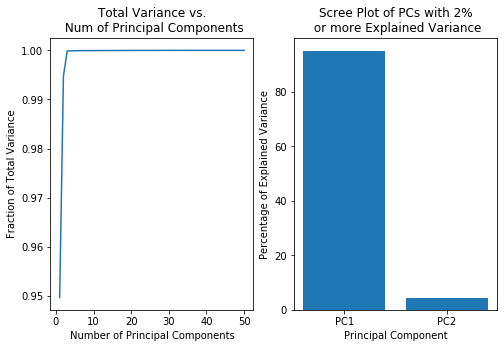

Top 10 features and their loading score influnce on PC1:
--------------------------------------------------------
Aspect               0.985307
Average_Hillshade   -0.170770
Slope                0.002795
Wilderness_Area1    -0.000517
Soil_Type10          0.000397
Wilderness_Area4     0.000329
Soil_Type30         -0.000176
Soil_Type3          -0.000172
Soil_Type29         -0.000161
Wilderness_Area3     0.000143
dtype: float64


In [6]:
train_df['Average_Hillshade'] = ((train_df['Hillshade_9am']**2 +
                                 train_df['Hillshade_9am']**2 + train_df['Hillshade_9am']**2)/3)**0.5

test_df['Average_Hillshade'] = ((test_df['Hillshade_9am']**2 +
                                 test_df['Hillshade_9am']**2 + test_df['Hillshade_9am']**2)/3)**0.5

train_df = train_df.drop(columns=["Hillshade_9am"])
train_df = train_df.drop(columns=["Hillshade_Noon"])
train_df = train_df.drop(columns=["Hillshade_3pm"])
test_df = test_df.drop(columns=["Hillshade_9am"])
test_df = test_df.drop(columns=["Hillshade_Noon"])
test_df = test_df.drop(columns=["Hillshade_3pm"])

print("Converted Hillshade to average")
do_pca(train_df.to_numpy(), train_df.shape[1], k_principal_components = [1,2,3,4,5,10,20,30,40,50])

Next we can notice that soil types and wilderness areas are in the top 10.  Let's reduce these down to a categorical 1-40 and 1-4 value to reduce the feature space.

Converted soil types and wilderness areas


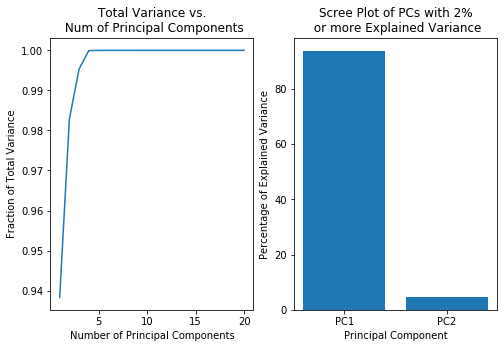

Top 10 features and their loading score influnce on PC1:
--------------------------------------------------------
Aspect                         0.985305
Average_Hillshade             -0.170771
Slope                          0.002798
SoilType                      -0.001513
WildernessArea                 0.001320
Roadway_Distance_Normal        0.000111
Fire_Points_Distance_Normal   -0.000077
Total_Distance_to_Hydrology    0.000061
Elevation_Normal              -0.000029
dtype: float64


In [7]:
def convert_soil_types_to_categorical(df):

    df["SoilType"] = 0
    columns = list(df)

    for col_name in columns:
        soil_type = 0
        if col_name[0:9] == 'Soil_Type':
            soil_type = int(col_name[9:])
            df["SoilType"] = df["SoilType"] + df[col_name]*soil_type
            df = df.drop(columns=[col_name])
            
    return df          
            
def convert_wilderness_areas_to_categorical(df):

    df["WildernessArea"] = 0
    columns = list(df)

    for col_name in columns:
        wild_area = 0
        if col_name[0:15] == 'Wilderness_Area':
            wild_area = int(col_name[15:])
            df["WildernessArea"] = df["WildernessArea"] + df[col_name]*wild_area

    for col_name in columns:
        if col_name[0:15] == 'Wilderness_Area':
            df = df.drop(columns=[col_name])

    return df

train_df = convert_soil_types_to_categorical(train_df)
test_df = convert_soil_types_to_categorical(test_df)

train_df = convert_wilderness_areas_to_categorical(train_df)
test_df = convert_wilderness_areas_to_categorical(test_df)

print("Converted soil types and wilderness areas")
do_pca(train_df.to_numpy(), train_df.shape[1], k_principal_components = [1,2,3,4,5,10,20])

Lastly, Aspect continues to have an influence on some of the parameters. Normally, aspect represents the cardinal direction the slope faces, with 0 corresponding to North, 90 to East, 180 to South, and 270 to West. However, geographical sources have found that sometimes only the relative direction between North and South is important for vegetation growth and type. Therefore, the 360 degree range was mapped to solely a 0 to 180 scale, regardless of whether the slope was also East or West facing.

Converted Aspect


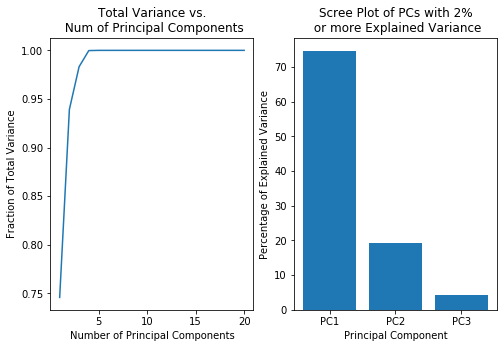

Top 10 features and their loading score influnce on PC1:
--------------------------------------------------------
Aspect                         0.943206
Average_Hillshade             -0.331528
SoilType                       0.021209
WildernessArea                 0.001116
Elevation_Normal              -0.000174
Slope                         -0.000062
Roadway_Distance_Normal       -0.000060
Total_Distance_to_Hydrology   -0.000010
Fire_Points_Distance_Normal    0.000005
dtype: float64


In [8]:
train_df['Aspect'] = abs(train_df['Aspect']-180)
test_df['Aspect'] = abs(test_df['Aspect']-180)
print("Converted Aspect")
do_pca(train_df.to_numpy(), train_df.shape[1], k_principal_components = [1,2,3,4,5,10,20])

We see this didn't have much an imact on the final load score.  However these seems sufficent for feature engineering, particularly using PCA analysis to help us do dimensin reduction.  Let's put it into a known good decision tree model to see how it does.

In [9]:
train_df.head()

,Aspect,Slope,Roadway_Distance_Normal,Fire_Points_Distance_Normal,Elevation_Normal,Total_Distance_to_Hydrology,Average_Hillshade,SoilType,WildernessArea
0,129,3,0.074020,0.897898,0.369084,0.190134,221.0,29,1
1,124,2,0.056604,0.890176,0.366062,0.156296,220.0,29,1
2,41,9,0.461538,0.875304,0.473817,0.203229,234.0,12,1
3,25,18,0.448476,0.888174,0.464250,0.198414,238.0,30,1
4,135,2,0.056749,0.882597,0.368580,0.112756,220.0,29,1


In [10]:
# Build the np arrays
train_data = train_df.to_numpy()
test_data = test_df.drop(columns=["Id"]).to_numpy()
train_labels = train_labels_df.to_numpy().ravel()

# Shuffle the input
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data, train_labels = train_data[shuffle], train_labels[shuffle]

# Set some variables to hold dev, and training data.
dev_data, dev_labels = train_data[14000:], train_labels[14000:]
train_data, train_labels = train_data[:14000], train_labels[:14000]

In [11]:
### Warning - this runs VERY slow with n_estimators at 1000 --> Changing to 100
ex = ExtraTreesClassifier(random_state=0, n_estimators = 100)
ex.fit(train_data, train_labels)
extra_trees_score = ex.score(dev_data, dev_labels)
print("Extra Trees Score: ", extra_trees_score)

print("Random Forest 10-Fold Cross Validation Scores: ")
extra_trees_cv_score = cross_val_score(ex, dev_data, dev_labels, cv = 10)
print(extra_trees_cv_score)
print("Mean: ", extra_trees_cv_score.mean())

print_importances(ex)

Extra Trees Score:  0.8901785714285714
Random Forest 10-Fold Cross Validation Scores: 
[0.75       0.73214286 0.73214286 0.78571429 0.76785714 0.74107143
 0.69642857 0.72321429 0.72321429 0.74107143]
Mean:  0.7392857142857143
                       feature  importance
4             Elevation_Normal      0.2467
7                     SoilType      0.1957
2      Roadway_Distance_Normal      0.1009
8               WildernessArea      0.0893
3  Fire_Points_Distance_Normal      0.0887
5  Total_Distance_to_Hydrology      0.0831
0                       Aspect      0.0709
6            Average_Hillshade      0.0695
1                        Slope      0.0551
